## Assignment 2 - Similar Items (Min Hashing)

In [1]:
#load data
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_df = pd.read_csv("train.csv")
print(train_df.shape)
train_df.head()

.\shingling.html
.\shingling.ipynb
.\shingling.pdf
.\shingling.zip
.\train.csv
(120000, 3)


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [2]:
#check for missing values
train_df.info()
train_df['Class Index'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

In [3]:
#consider only 200 docs from each class
train_df = train_df.groupby('Class Index').head(200).reset_index(drop=True)
train_df['Class Index'].value_counts()

#concatinate the title and the body of the article
train_df['text'] = train_df['Title'] + ' ' + train_df['Description']
# train_df['text'] = train_df['Title']

#drop the title and the article columns
train_df = train_df.drop(['Title', 'Description'], axis=1)

#print 5 samples from each class
for i in range(1, 4):
    print(train_df[train_df['Class Index'] == i].head(3))
    print('\n\n\n')


     Class Index                                               text
322            1  Venezuelans Vote Early in Referendum on Chavez...
323            1  S.Koreans Clash with Police on Iraq Troop Disp...
324            1  Palestinians in Israeli Jails Start Hunger Str...




     Class Index                                               text
278            2  Phelps, Thorpe Advance in 200 Freestyle (AP) A...
279            2  Reds Knock Padres Out of Wild-Card Lead (AP) A...
280            2  Dreaming done, NBA stars awaken to harsh Olymp...




   Class Index                                               text
0            3  Wall St. Bears Claw Back Into the Black (Reute...
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...
2            3  Oil and Economy Cloud Stocks' Outlook (Reuters...






- Clean the input string by removing all stopwords and punctuation.

In [4]:
#remove the stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_df.head()

#remove the punctuation and special characters
import string
train_df['text'] = train_df['text'].str.replace('[{}]'.format(string.punctuation), '')
train_df.head()

,Class Index,text
0,3,Wall St. Bears Claw Back Into Black (Reuters) ...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil Economy Cloud Stocks' Outlook (Reuters) Re...
3,3,Iraq Halts Oil Exports Main Southern Pipeline ...
4,3,"Oil prices soar all-time record, posing new me..."


- Split the text field of the dataframe into a list of words based on given k size of shingles.

In [5]:
def create_shingles(text: str, k: int):
    shingle_set = []
    for i in range(len(text) - k+1):
        shingle_set.append(text[i:i+k])
    return set(shingle_set)

def build_shingles(df, k):
    shingles = []
    for i in range(len(df)):
        shingles.append(create_shingles(df['text'][i], k))
    return shingles

def build_vocab(shingles):
    vocab = set()
    for shingle in shingles:
        vocab = vocab.union(shingle)
    return list(vocab)

1. Construct several types of K-shingles (5, 8 and 10).

In [6]:
shingle_sizes = [5, 8, 10]

shingles = {}
vocab = {}
for k in shingle_sizes:
    shingles[k] = build_shingles(train_df, k)
    vocab[k] = build_vocab(shingles[k])
    vocab[k] = list(vocab[k])
    print(f"Vocab size for k={k}: {len(vocab[k])}")

Vocab size for k=5: 60316
Vocab size for k=8: 112231
Vocab size for k=10: 125435


- Building a minhash signature matrix for each type of shingles us the following steps:

    - Create a list of hash functions.
    - Create a signature matrix with the size of the number of hash functions and the number of documents.
    - For each document, hash each shingle and update the signature matrix.
    - Return the signature matrix.

The sets of shingles are large. Even if we hash them to four bytes each, the space
needed to store a set is still roughly four times the space taken by the document.
If we have millions of documents, it may well not be possible to store all the
shingle-sets in main memory.

There is another serious concern: even if the sets fit in main memory, the number of pairs
may be too great for us to evaluate the similarity of each pair.

> Reference: Mining of Massive Datasets by Jure Leskovec, Anand Rajaraman, Jeff Ullman
> http://infolab.stanford.edu/~ullman/mmds/book.pdf

 Rather than generating a random permutation of all possible shingles, 
 we'll just hash the IDs of the shingles that are *actually in the document*,
then take the lowest resulting hash code value. This corresponds to the index 
of the first shingle that you would have encountered in the random order.



In [7]:
#create a set of hash functions
import hashlib, random
class hashFamily:
    def __init__(self, i):
        self.resultSize = 4 # how many bytes we want back
        self.maxLen = 20 # how long can our salt be (in decimal)
        self.salt = str(i).zfill(self.maxLen)[-self.maxLen:]

    def get_hash_value(self, el_to_hash):
        return int(hashlib.sha1(str(el_to_hash).encode('utf-8') + self.salt.encode('utf-8')).hexdigest()[-self.resultSize:], 16) 

In [8]:
def create_hash_funcs(num_hashes):
    return [hashFamily(random.randint(0,10000000000)) for i in range(num_hashes)]

def compute_signature(shingle, hash_funcs):
    signature = []
    for i in range(len(hash_funcs)):
        min_hash = float('inf')
        for sh in shingle:
            h = hash_funcs[i].get_hash_value(sh)
            if h < min_hash:
                min_hash = h
        signature.append(min_hash)
    return signature

#compute the signature matrix
def compute_signature_matrix(shingles, hash_funcs):
    signature_matrix = []
    for shingle in shingles:
        signature_matrix.append(compute_signature(shingle, hash_funcs))
    return np.array(signature_matrix)

2. Build a minhash signature for the above K-shingles.
   
- For each signature length, construct a minhash signature matrix for each type of shingles.

In [9]:
#test with varioust signature lengths
signature_lengths = [5, 10, 20]

#store the signature matrix for each signature length
signature_matrices = {}

for signature_length in signature_lengths:
    hash_funcs = create_hash_funcs(signature_length)
    for k in shingle_sizes:
        signature_matrices[(k, signature_length)] = compute_signature_matrix(shingles[k], hash_funcs)
        print(signature_matrices[(k, signature_length)].shape)



(800, 5)
(800, 5)
(800, 5)
(800, 10)
(800, 10)
(800, 10)
(800, 20)
(800, 20)
(800, 20)


In [10]:
#check the similarity
def jaccard(a: set, b: set):
    return len(a.intersection(b)) / len(a.union(b))

def dice_coefficient(a: set, b: set):
    return 2 * len(a.intersection(b)) / (len(a) + len(b))

3. Compute the Jaccard similarity between all pairs of documents for each type of shingle. Compare the pair-wise similarity between Signature matrix and Singling Matrix. 

In [11]:
# 3. Compute the Jaccard similarity between 30 of documents for each type of shingle. 
# Compare the pair-wise similarity between Signature matrix and Singling Matrix. 
def jaccard_similarity(matrix):
    jaccard_sim = np.zeros((len(matrix), len(matrix)))
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            jaccard_sim[i][j] = jaccard(set(matrix[i]), set(matrix[j]))
    return pd.DataFrame(jaccard_sim)

In [12]:
#take 30 documents from each class
jaccard_sim_shingles = {}
for k in shingle_sizes:
    jaccard_sim_shingles[k] = jaccard_similarity(shingles[k][:30])

jaccard_sim_shingles[5].head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.000000,0.042553,0.057348,0.044164,0.000000,0.047619,0.000000,0.000000,0.000000,0.748252,...,0.003906,0.000000,0.000000,0.004132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.042553,1.000000,0.045333,0.038835,0.009852,0.033898,0.025974,0.007126,0.021154,0.020588,...,0.000000,0.009259,0.000000,0.008902,0.000000,0.000000,0.009317,0.011527,0.005865,0.003135
2,0.057348,0.045333,1.000000,0.041096,0.025496,0.076705,0.020588,0.027322,0.008351,0.023973,...,0.013245,0.033333,0.015385,0.017422,0.014815,0.014337,0.003623,0.010000,0.010274,0.000000
3,0.044164,0.038835,0.041096,1.000000,0.005051,0.040100,0.005249,0.007335,0.005814,0.021341,...,0.000000,0.016129,0.003344,0.006135,0.000000,0.006309,0.009677,0.000000,0.000000,0.000000
4,0.000000,0.009852,0.025496,0.005051,1.000000,0.025840,0.000000,0.018088,0.002000,0.003165,...,0.000000,0.017123,0.014388,0.003236,0.028169,0.013468,0.003401,0.009434,0.000000,0.000000


In [13]:
#compute the jaccard similarity between the signature matrix for each signature length
#store the results in a dictionary
jaccard_similarities = {}
for signature_length in signature_lengths:
    for k in shingle_sizes:
        jaccard_similarities[(k, signature_length)] = jaccard_similarity(signature_matrices[(k, signature_length)][:30])

jaccard_similarities[(5, 5)].head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.000,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.125,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


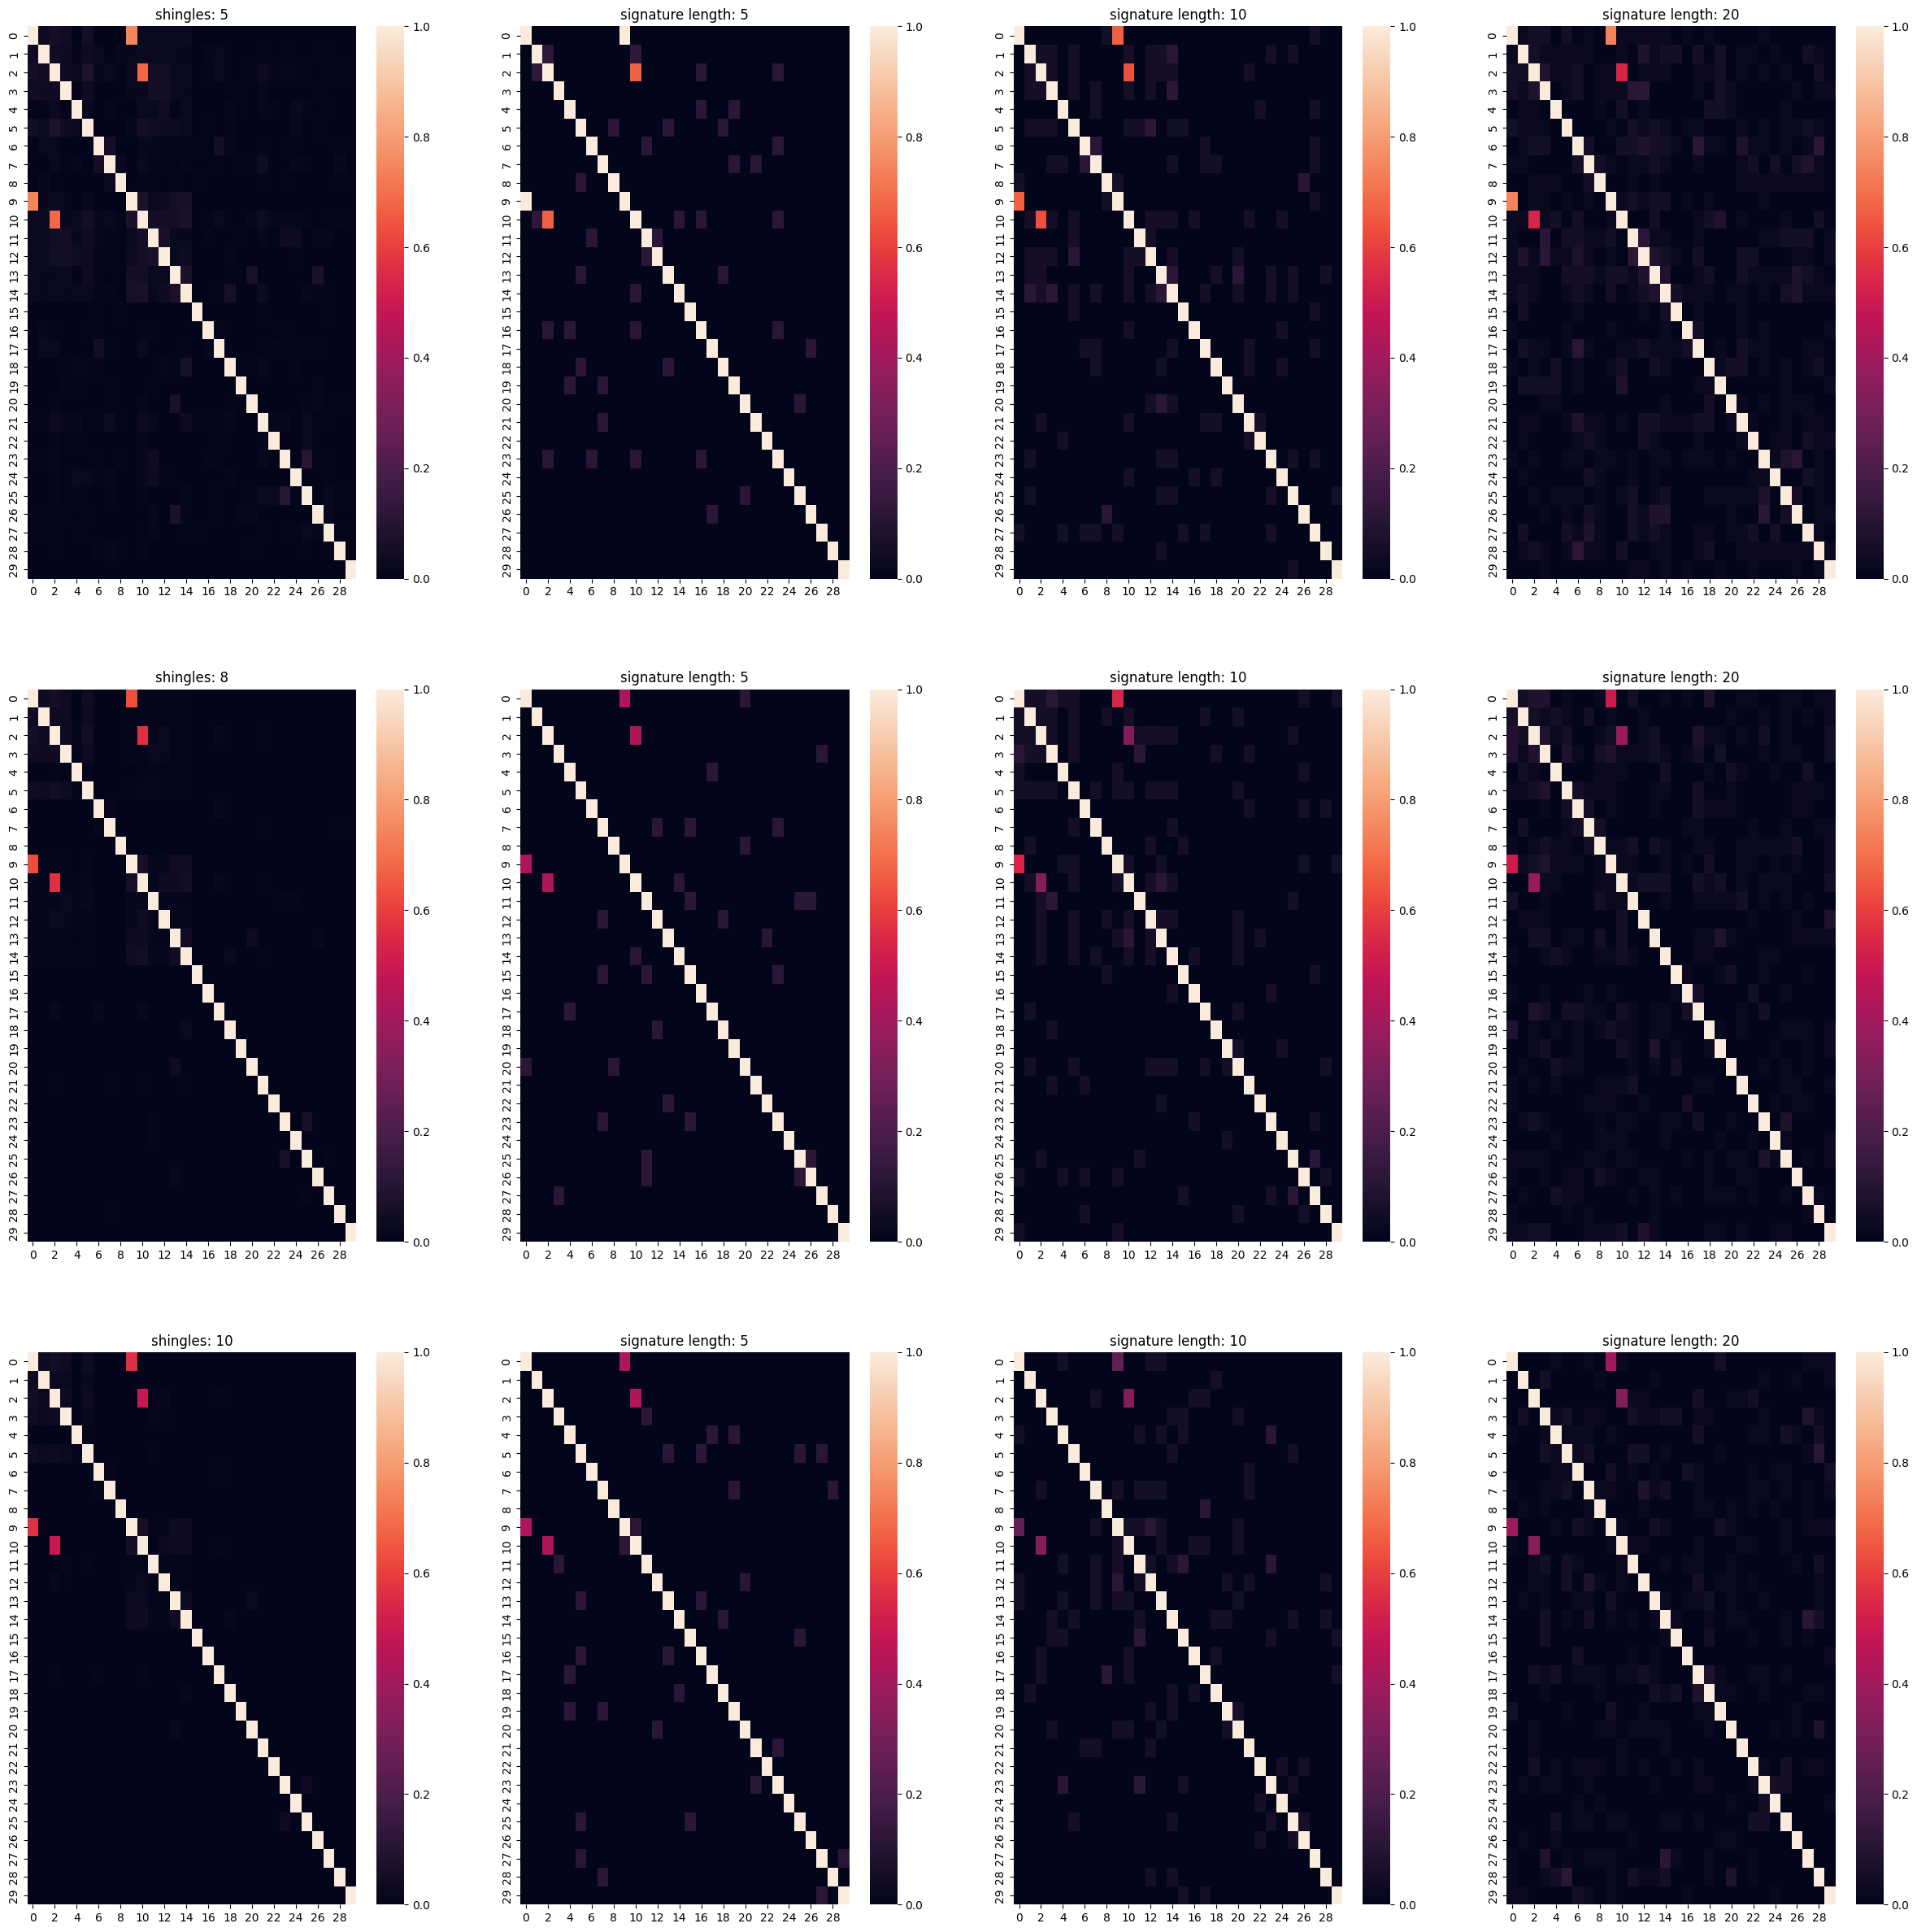

In [14]:
#plot the jaccard similarity between the shingles and the signature matrix on the same plot with different colors
import matplotlib.pyplot as plt
import seaborn as sns

#for each signature length, plot the jaccard similarity between the shingles and the signature matrix
fig, ax = plt.subplots(len(shingle_sizes), len(signature_lengths) + 1, figsize=(30, 30))
#first column for shingles, the rest for the signature matrix for each signature length
for i, k in enumerate(shingle_sizes):
    sns.heatmap(jaccard_sim_shingles[k], ax=ax[i][0])
    ax[i][0].set_title(f'shingles: {k}')
    for j, signature_length in enumerate(signature_lengths):
        sns.heatmap(jaccard_similarities[(k, signature_length)], ax=ax[i][j+1])
        ax[i][j+1].set_title(f'signature length: {signature_length}')
    ax[i][0].set_title(f'shingles: {k}')
plt.show()   

In [15]:
# 4. Use any other similarity function and find the Signature matric based similarity.
#compute the dice coefficient between the shingles
def dice_similarity(matrix):
    dice_sim = np.zeros((len(matrix), len(matrix)))
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            dice_sim[i][j] = dice_coefficient(set(matrix[i]), set(matrix[j]))
    return pd.DataFrame(dice_sim)

In [16]:
#take 30 documents from each class
dice_sim_shingles = {}
for k in shingle_sizes:
    dice_sim_shingles[k] = dice_similarity(shingles[k][:30])

#compute the dice similarity between the signature matrix for each signature length
#store the results in a dictionary
dice_similarities = {}
for signature_length in signature_lengths:
    for k in shingle_sizes:
        dice_similarities[(k, signature_length)] = dice_similarity(signature_matrices[(k, signature_length)][:30])

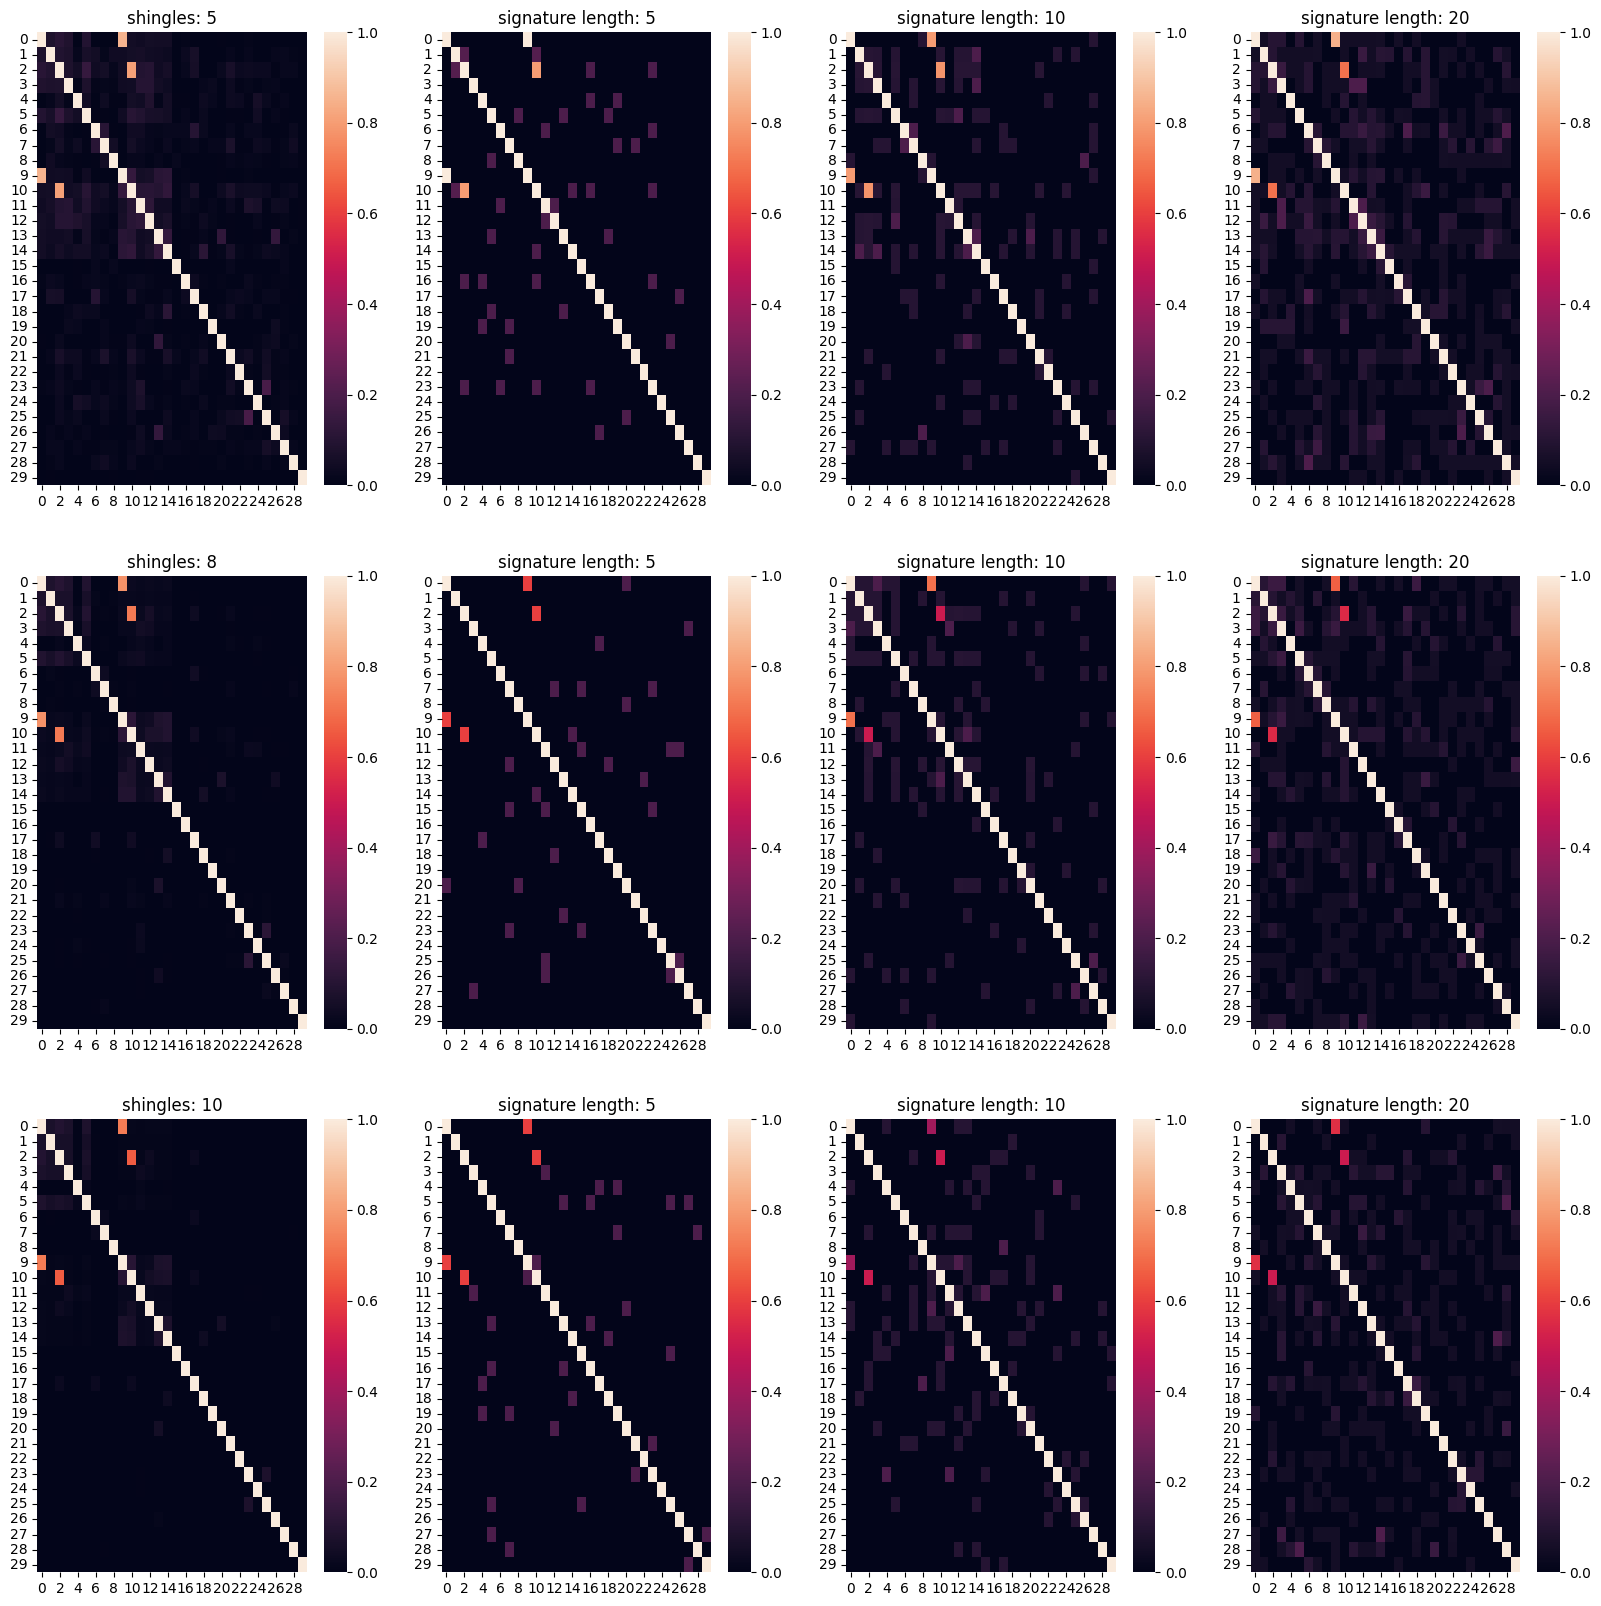

In [17]:
#plot the dice coefficient between the shingles and the signature matrix on the same plot with different colors
#for each signature length, plot the jaccard similarity between the shingles and the signature matrix
fig, ax = plt.subplots(len(shingle_sizes), len(signature_lengths) + 1, figsize=(20, 20))
#first column for shingles, the rest for the signature matrix for each signature length
for i, k in enumerate(shingle_sizes):
    sns.heatmap(dice_sim_shingles[k], ax=ax[i][0])
    ax[i][0].set_title(f'shingles: {k}')
    for j, signature_length in enumerate(signature_lengths):
        sns.heatmap(dice_similarities[(k, signature_length)], ax=ax[i][j+1])
        ax[i][j+1].set_title(f'signature length: {signature_length}')
    ax[i][0].set_title(f'shingles: {k}')
plt.show()  


#### Conclusions and Findings:

- Increasing the shingle size, increase the total number of unique shingles.
- The Jaccard similarity between all pairs of documents for each type of shingle is consistent with the actual Jaccard similarity between the documents.
  - As expected, increasing the signature length increases the accuracy of the Jaccard similarity, but at the cost of increased computation time.
  - Similarly, for Dice similarity, increasing the signature length increases the accuracy of the Dice similarity.

- Comparing the results of Jaccard and Dice similarity, we can conclude that the Dice coefficient is more effective in measuring the similarity between two sets. 
